In [1]:
# Load packages
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
#pip install -q -U keras-tuner
import keras_tuner as kt

#import tensorflow.compat.v2 as tf
from keras import layers, models, metrics
import time
import python_utils

import glob
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, auc


import os
import pickle
import glob
import scipy.signal
import cv2
import sklearn
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, auc
import datetime

In [2]:
######### Spectrogram calculation and enhancement ###########

def loadShot(shotn,ece_chn):
    # data_spec = pickle.load(open(os.path.join('/projects/EKOLEMEN/negd_ece/negd_spec/','%d.pkl' % (shotn)),'rb'))
    #rb is read binary 
    data_raw = pickle.load(open(os.path.join('/projects/EKOLEMEN/negd_ece/negd_raw/','%d.pkl' % (shotn)),'rb')) 
    return specgr (data_raw[f'ECEVS{ece_chn:02d}'],spec_params)


def specgr (sig_in,spec_params,thr=0.9, gaussblr_win=(31,3)):
    f, t, Sxx = scipy.signal.spectrogram(sig_in, nperseg=spec_params['nperseg'], noverlap=spec_params['noverlap'],fs=spec_params['fs'], window=spec_params['window'],scaling=spec_params['scaling'], detrend=spec_params['detrend'])
    Sxx = np.log(Sxx + spec_params['eps']) #offset by epsilon to prevent log(0)
    Sxx=(Sxx-np.min(Sxx))/(np.max(Sxx)-np.min(Sxx)) #z score scaling
    Sxx = Sxx[:-1,:];f=f[:-1] 
    
    Sxx_enhanced = quantfilt(Sxx,thr) 
    Sxx_enhanced = gaussblr(Sxx_enhanced,gaussblr_win)
    Sxx_enhanced = meansub(Sxx_enhanced)    
    Sxx_enhanced = morph(Sxx_enhanced)
    Sxx_enhanced = meansub(Sxx_enhanced)    
    return Sxx,Sxx_enhanced,f/1000,t


def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

# gaussian filtering (just get middle part, filter out highs and lows)
def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

# mean filtering
def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

# morphological filtering
def morph(src):
    src = (rescale(src)*255).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return rescale(mask)

spec_params={
    'nperseg': 800, # default 1024
    'noverlap': 550, # default: nperseg / 4
    'fs': 500000, # raw signal sample rate is 4MHz
    'window': 'hamm',
    'scaling': 'density', # {'density', 'spectrum'}
    'detrend': 'linear', # {'linear', 'constant', False}
    'eps': 1e-11} 


In [3]:
# precision and recall evaluations to decide best threshold
def scores(TP, TN, FP, FN):
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [4]:
# normal dataset splitting
def splitDatasets(data, labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=2)
    return x_train, x_val, x_test

# dataset splitting to keep mode portions together, and keep modeless portions together
def splitWithoutLabels(data, labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=2)

    x_train = squeeze(x_train)
    x_val = squeeze(x_val)
    x_test = squeeze(x_test)

    return x_train, x_val, x_test

# condense array by one dimension
def squeeze(a):
    newA = []
    for i in a:
        newA += i
    return newA

# pair the shortest and longest spectrograms in mode/modeless dataset
def sortByPairs(a):
    c = []
    if len(a)%2 == 1:
        upperBound = len(a)//2 + 1
    else:
        upperBound = len(a)//2

    for i in range(upperBound):
        short = a[i]
        long = a[len(a)-i-1]

        if i == len(a)-i-1:
            c.append(short)
        else:
            c.append(short + long)
    return c


In [6]:
allModes = []   # whole mode portions of every channel
allModeless = []  # whole modeless portions of every channel

modeLabels = []
modelessLabels = []

modeCount = 0
modelessCount = 0

for file in glob.glob("/scratch/gpfs/aj17/datasets/NT-dataset/dataset/mode/*.pkl"):
    modes = []   # time slices with mode
    modeless = [] #time slices without mode

    a = pickle.load(open(file, 'rb'))
    
    spec = a['raw spectrogram']
    
    for i in range(spec.shape[1]):
        if a['label'][i] == 1.0:
            modes.append(spec[:30, i])   # first 30 frequenecies 
            modeCount += 1
            
        else:
            modeless.append(spec[:30, i])
            modelessCount += 1
    
    allModes.append(modes)
    allModeless.append(modeless)


for file in glob.glob("/scratch/gpfs/aj17/datasets/NT-dataset/dataset/nomode/*.pkl"):
    #compile spectrograms into X_train and labels into Y_train
    modeless = []
    a = pickle.load(open(file, 'rb'))
    
    spec = a['raw spectrogram']
    for i in range(spec.shape[1]):
        modeless.append(spec[:30, i])
        modelessCount+= 1
  
    allModeless.append(modeless)

np.random.seed(15)

print(len(allModes))
print(modelessCount)
print(modeCount)


# split into training, validation, and test
allModes = sorted(allModes, key=lambda x: len(x))  # sort from least # of elements to greatest

allModes = sortByPairs(allModes) # pair shortest and longest spectrograms in 2-element arrays

labels = np.zeros(len(allModes))
x_trainM, x_valM, x_testM= splitWithoutLabels(allModes, labels)

xi = len(x_trainM)   # training dataset
xv = len(x_valM)    #validation dataset
xt = len(x_testM)   #test dataset
print(xi, xv, xt)
print(xi/(xi+xv+xt))   # approximately 60%
print(xv/(xi+xv+xt))   # ~20%
print(xt/(xi+xv+xt))   # ~20%

# labels for mode part of each dataset
y_trainM = [1.0]*len(x_trainM)
y_valM = [1.0]*len(x_valM)
y_testM = [1.0]*len(x_testM)

#prepare dataset of modeless portions in the same way
allModeless = sorted(allModeless, key=lambda x: len(x))  # sort from least # of elements to greatest

allModeless = sortByPairs(allModeless) # put them into tuple arrays of most and least elements

#prepare dataset of modeless
labels = np.zeros(len(allModeless))
x_trainMo, x_valMo, x_testMo= splitWithoutLabels(allModeless, labels)
print(len(x_trainMo))
print(len(x_valMo))
print(len(x_testMo))

# labels for modeless part of each dataset
y_trainMo = [0.0]*len(x_trainMo)
y_valMo = [0.0]*len(x_valMo)
y_testMo = [0.0]*len(x_testMo)

# putting together datasets
X_train = np.asarray(x_trainM + x_trainMo)
X_val = np.asarray(x_valM + x_valMo)
X_test = np.asarray(x_testM + x_testMo)

y_train = np.asarray(y_trainM + y_trainMo)
y_val = np.asarray(y_valM + y_valMo)
y_test = np.asarray(y_testM + y_testMo)

#check dataset length
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

#check label length
print(len(y_train))
print(len(y_val))
print(len(y_test))

110
643575
399869
239354 79534 80981
0.5985810352890572
0.1989001397957831
0.2025188249151597
366940
132839
143796
(606294, 30)
(212373, 30)
(224777, 30)
606294
212373
224777


In [ ]:

## with whole mode and modeless portions of each channel
n_epochs = 10
hidden_units1 = 350
hidden_units2 = 150
hidden_units3 = 70
dropout = 0.15
n_labels = 1

# Baseline three-layer MLP
model = models.Sequential()
model.add(layers.Dense(hidden_units1,
                       input_dim=X_train.shape[-1],
                       activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(hidden_units2, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(hidden_units3, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(n_labels, activation='sigmoid'))

# Plot the performance
#model.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])
model.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.AUC(from_logits=True)])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=n_epochs,
                    batch_size=10000,
                    )

print(history)
print("Done fitting model, now plotting")
model.summary()

In [50]:
# serialize model to JSON
model_json = model.to_json()
with open('/scratch/gpfs/kx2561/ML/rawSpecModels/rawSpec_30f/newest_MLPmodel_30freq.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('/scratch/gpfs/kx2561/ML/rawSpecModels/newest_MLPmodel_30freq.h5')
print("Saved model to disk")



Saved model to disk


In [ ]:
####################   evaluate model performance ######################################

In [7]:
# load raw 30 freq model 
json_file = open('/scratch/gpfs/kx2561/ML/rawSpecModels/rawSpec_30f/newest_MLPmodel_30freq.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
rawModel = model_from_json(loaded_model_json)
# load weights into new model
rawModel.load_weights('/scratch/gpfs/kx2561/ML/rawSpecModels/rawSpec_30f/newest_MLPmodel_30freq.h5')
print("Loaded model from disk")

Loaded model from disk


2023-09-04 16:34:12.043342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30177 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2023-09-04 16:34:12.046732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26285 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0


Text(0.5, 1.0, 'Confusion Matrix on Test Dataset- Raw Spectrogram')

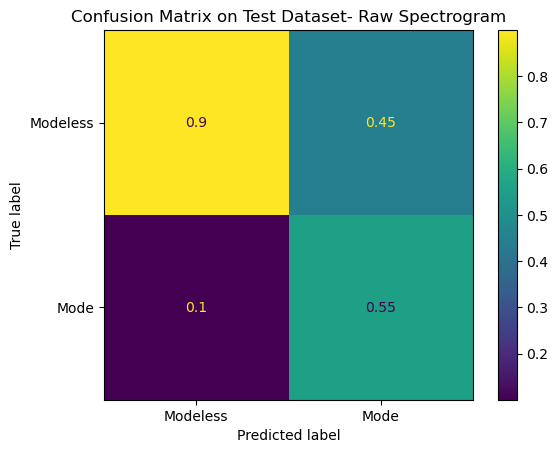

In [10]:
# Model evaluation: confusion matrix
threshold = 0.378

cm = confusion_matrix(y_test, predict_testLabel, labels=[0, 1], normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Modeless", "Mode"])
disp.plot()
plt.title("Confusion Matrix on Test Dataset- Raw Spectrogram")

18947/18947 [==============================] - 24s 1ms/step


Text(0.5, 1.0, 'Raw Spectrogram, 30 lowest frequencies-- ROC curve on Training Dataset')

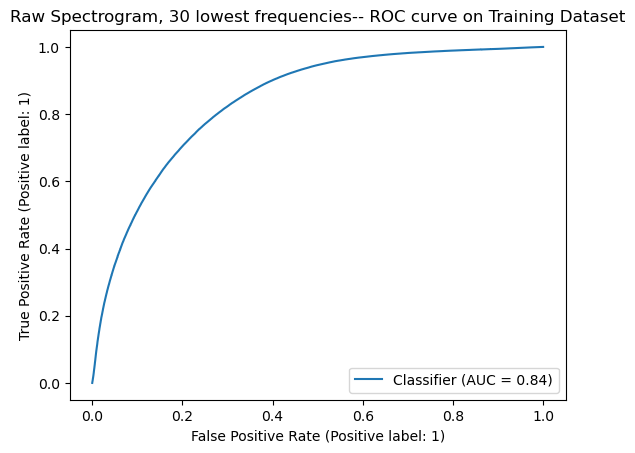

In [11]:
# ROC curve
pred_train = rawModel.predict(X_train)
RocCurveDisplay.from_predictions(y_train, pred_train)
plt.title("Raw Spectrogram, 30 lowest frequencies-- ROC curve on Training Dataset")

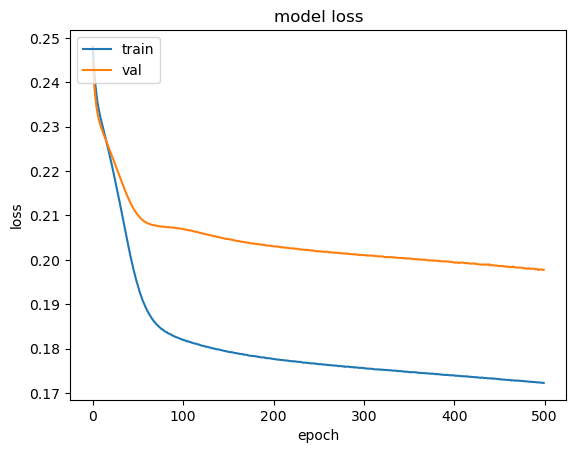

In [29]:
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [12]:
# find best prediction threshold for training and validation
pred_train = rawModel.predict(X_train)
pred_val = rawModel.predict(X_val)

thresholds = np.arange(0.2, 0.8, 0.01)
prec = []
rec = []
f1s = []

for threshold in thresholds:
    predict_trainLabel = pred_train.flatten()>threshold

    cm = confusion_matrix(y_train, predict_trainLabel, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    precision, recall, f1 = scores(tp, tn, fp, fn)
    prec.append(precision)
    rec.append(recall)
    f1s.append(f1)

df = pd.DataFrame({'Threshold': thresholds, 'Precision': prec, 'Recall': rec, 'F1 score': f1s})
df.head()

6637/6637 [==============================] - 8s 1ms/step


,Threshold,Precision,Recall,F1 score
0,0.20,0.567161,0.932869,0.705435
1,0.21,0.572205,0.927643,0.707808
2,0.22,0.577115,0.922717,0.710098
3,0.23,0.581789,0.917449,0.712044
4,0.24,0.586275,0.912147,0.713776


Text(0, 0.5, 'Precision/Recall value')

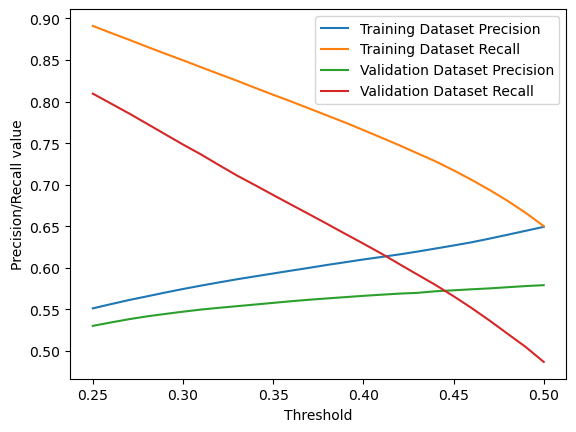

In [11]:
# visualize tradeoff between precision and recall
plt.plot(thresholds, prec, label = 'Training Dataset Precision')
plt.plot(thresholds, rec, label = 'Training Dataset Recall')
plt.plot(thresholds, prec_val, label = 'Validation Dataset Precision')
plt.plot(thresholds, rec_val, label = 'Validation Dataset Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall value')